In [ ]:
conda activate TFgpu

<div align="center">
  <img src="DisplayIMG/Cartoon.png" alt="Image Description" />
</div>

In [ ]:
num_cores = os.cpu_count()  # Get number of CPU cores
num_cores_to_use = num_cores // 2  # Use half of the cores

num_cores

In [ ]:
num_cores_to_use

In [3]:
import cv2
import os
import numpy as np
from PIL import Image
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import glob
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_tuner import BayesianOptimization, HyperParameters


In [ ]:
#Run and tune Hyperparameters

#----------------------------------------------------------------------

import cv2
import os
import numpy as np
from PIL import Image
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import glob
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_tuner import BayesianOptimization, HyperParameters
import pickle

# Get the current directory
current_directory = os.getcwd()

# Specify the folder name where the images are located
folder_name = "img"

# Construct the folder path
folder_path = os.path.join(current_directory, folder_name)

# Specify the CSV file path containing image labels
csv_file_path = os.path.join(current_directory, "labels", "english-clean.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Create a dictionary where keys are filenames and values are labels
labels_dict = df.set_index('image')['label'].to_dict()

def load_images_from_folder(folder, labels_dict):
    images = []
    labels = []
    for file_path in glob.glob(os.path.join(folder, "*.png")):
        img = Image.open(file_path)
        if img is not None:
            img = img.convert('L')  # Convert image to grayscale
            img = img.resize((64, 64))  # Resize the image
            np_img = np.array(img)
            images.append(np_img)
            filename = os.path.basename(file_path)
            label = labels_dict[filename]  # Get the label from the filename
            labels.append(label)
    return images, labels

images, labels = load_images_from_folder(folder_path, labels_dict)

le = preprocessing.LabelEncoder()
numerical_labels = le.fit_transform(labels)  # Convert labels to integers

images = np.array(images)  # Convert list of arrays to a single array
images = images / 255.0  # Normalize pixel values
images = images.reshape(-1, 64, 64, 1)  # Reshape array for CNN

encoded_labels = to_categorical(numerical_labels)  # One-hot encode labels

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42, shuffle=True)

def build_model(hp):
    model = Sequential()

    # First block of convolutions
    model.add(Conv2D(hp.Int('conv_1_units', min_value=32, max_value=256, step=32), 
                     (3, 3), 
                     activation='relu', 
                     input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # Second block of convolutions
    model.add(Conv2D(hp.Int('conv_2_units', min_value=32, max_value=256, step=32), 
                     (3, 3), 
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_1_units', min_value=32, max_value=1024, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(len(le.classes_), activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

tuner = BayesianOptimization(
    build_model,  # The function to construct the model
    objective='val_accuracy',  # The metric to be optimized
    max_trials=20,  # The maximum number of iterations for tuning
    executions_per_trial=2,  # The number of models that should be built and fit for each trial for robustness purposes
    directory=os.path.normpath('C:/keras_tuning'),  # The path to the directory where the search results are stored
    project_name='keras_tuner_demo',  # The name of the project. This will be the name of the subdirectory under `directory` where the results are saved
    overwrite=True  # Whether or not to overwrite the project if it already exists
)

tuner.search_space_summary()

tuner.search(
    X_train,  # Training data
    y_train,  # Training labels
    epochs=60,  # The number of epochs for training
    validation_data=(X_test, y_test),  # Validation data
    callbacks=[early_stopping, model_checkpoint]  # Callbacks to be used during training
)

tuner.results_summary()

# Save the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
with open('best_hyperparameters.pkl', 'wb') as file:
    pickle.dump(best_hyperparameters.values, file)

    
#Run Model off of tuned Hyperparameters

#----------------------------------------------------------------

import cv2
import os
import numpy as np
from PIL import Image
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import glob
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_tuner import HyperParameters

# Get the current directory
current_directory = os.getcwd()

# Specify the folder name where the images are located
folder_name = "img"

# Construct the folder path
folder_path = os.path.join(current_directory, folder_name)

# Specify the CSV file path containing image labels
csv_file_path = os.path.join(current_directory, "labels", "english-clean.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Create a dictionary where keys are filenames and values are labels
labels_dict = df.set_index('image')['label'].to_dict()

def load_images_from_folder(folder, labels_dict):
    images = []
    labels = []
    for file_path in glob.glob(os.path.join(folder, "*.png")):
        img = Image.open(file_path)
        if img is not None:
            img = img.convert('L')  # Convert image to grayscale
            img = img.resize((64, 64))  # Resize the image
            np_img = np.array(img)
            images.append(np_img)
            filename = os.path.basename(file_path)
            label = labels_dict[filename]  # Get the label from the filename
            labels.append(label)
    return images, labels

images, labels = load_images_from_folder(folder_path, labels_dict)

le = preprocessing.LabelEncoder()
numerical_labels = le.fit_transform(labels)  # Convert labels to integers

images = np.array(images)  # Convert list of arrays to a single array
images = images / 255.0  # Normalize pixel values
images = images.reshape(-1, 64, 64, 1)  # Reshape array for CNN

encoded_labels = to_categorical(numerical_labels)  # One-hot encode labels

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42, shuffle=True)

# Specify the file path to the saved hyperparameters
hyperparameters_file_path = 'best_hyperparameters.pkl'

# Load the saved hyperparameters
with open(hyperparameters_file_path, 'rb') as file:
    loaded_hyperparameters_dict = pickle.load(file)

# Create a new HyperParameters object and set the loaded hyperparameters
loaded_hyperparameters = HyperParameters()
loaded_hyperparameters.values = loaded_hyperparameters_dict

def build_model(hp):
    model = Sequential()

    # First block of convolutions
    model.add(Conv2D(loaded_hyperparameters.get('conv_1_units'), 
                     (3, 3), 
                     activation='relu', 
                     input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(loaded_hyperparameters.get('dropout_1')))

    # Second block of convolutions
    model.add(Conv2D(loaded_hyperparameters.get('conv_2_units'), 
                     (3, 3), 
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(loaded_hyperparameters.get('dropout_2')))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(loaded_hyperparameters.get('dense_1_units'), activation='relu'))
    model.add(Dropout(loaded_hyperparameters.get('dropout_3')))
    model.add(Dense(len(le.classes_), activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(loaded_hyperparameters.get('learning_rate')), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=100)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Build and train the model with the loaded hyperparameters
best_model = build_model(loaded_hyperparameters)
history = best_model.fit(X_train, 
                         y_train, 
                         epochs=50, 
                         validation_data=(X_test, y_test), 
                         callbacks=[early_stopping, model_checkpoint])

# Plotting the accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print a classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


In [4]:
#Run and tune Hyperparameters

#----------------------------------------------------------------------

import cv2
import os
import numpy as np
from PIL import Image
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import glob
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_tuner import BayesianOptimization, HyperParameters
import pickle

# Get the current directory
current_directory = os.getcwd()

# Specify the folder name where the images are located
folder_name = "img"

# Construct the folder path
folder_path = os.path.join(current_directory, folder_name)

# Specify the CSV file path containing image labels
csv_file_path = os.path.join(current_directory, "labels", "english-clean.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Create a dictionary where keys are filenames and values are labels
labels_dict = df.set_index('image')['label'].to_dict()

def load_images_from_folder(folder, labels_dict):
    images = []
    labels = []
    for file_path in glob.glob(os.path.join(folder, "*.png")):
        img = Image.open(file_path)
        if img is not None:
            img = img.convert('L')  # Convert image to grayscale
            img = img.resize((64, 64))  # Resize the image
            np_img = np.array(img)
            images.append(np_img)
            filename = os.path.basename(file_path)
            label = labels_dict[filename]  # Get the label from the filename
            labels.append(label)
    return images, labels

images, labels = load_images_from_folder(folder_path, labels_dict)

le = preprocessing.LabelEncoder()
numerical_labels = le.fit_transform(labels)  # Convert labels to integers

images = np.array(images)  # Convert list of arrays to a single array
images = images / 255.0  # Normalize pixel values
images = images.reshape(-1, 64, 64, 1)  # Reshape array for CNN

encoded_labels = to_categorical(numerical_labels)  # One-hot encode labels

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42, shuffle=True)

def build_model(hp):
    model = Sequential()

    # First block of convolutions
    model.add(Conv2D(hp.Int('conv_1_units', min_value=32, max_value=256, step=32), 
                     (3, 3), 
                     activation='relu', 
                     input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # Second block of convolutions
    model.add(Conv2D(hp.Int('conv_2_units', min_value=32, max_value=256, step=32), 
                     (3, 3), 
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_1_units', min_value=32, max_value=1024, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(len(le.classes_), activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

tuner = BayesianOptimization(
    build_model,  # The function to construct the model
    objective='val_accuracy',  # The metric to be optimized
    max_trials=20,  # The maximum number of iterations for tuning
    executions_per_trial=2,  # The number of models that should be built and fit for each trial for robustness purposes
    directory=os.path.normpath('C:/keras_tuning'),  # The path to the directory where the search results are stored
    project_name='keras_tuner_demo',  # The name of the project. This will be the name of the subdirectory under `directory` where the results are saved
    overwrite=True  # Whether or not to overwrite the project if it already exists
)

tuner.search_space_summary()

tuner.search(
    X_train,  # Training data
    y_train,  # Training labels
    epochs=60,  # The number of epochs for training
    validation_data=(X_test, y_test),  # Validation data
    callbacks=[early_stopping, model_checkpoint]  # Callbacks to be used during training
)

tuner.results_summary()

# Save the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
with open('best_hyperparameters.pkl', 'wb') as file:
    pickle.dump(best_hyperparameters.values, file)


Trial 20 Complete [00h 06m 30s]
val_accuracy: 0.5285923779010773

Best val_accuracy So Far: 0.6055718660354614
Total elapsed time: 02h 03m 30s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:\keras_tuning\keras_tuner_demo
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 18 summary
Hyperparameters:
conv_1_units: 160
dropout_1: 0.0
conv_2_units: 64
dropout_2: 0.2
dense_1_units: 800
dropout_3: 0.4
learning_rate: 0.00022878229268157214
Score: 0.6055718660354614

Trial 13 summary
Hyperparameters:
conv_1_units: 256
dropout_1: 0.1
conv_2_units: 128
dropout_2: 0.4
dense_1_units: 320
dropout_3: 0.2
learning_rate: 1.3014694810000588e-05
Score: 0.6041055917739868

Trial 10 summary
Hyperparameters:
conv_1_units: 192
dropout_1: 0.2
conv_2_units: 32
dropout_2: 0.0
dense_1_units: 896
dropout_3: 0.30000000000000004
learning_rate: 3.022065504103985e-05
Score: 0.5916422307491302

Trial 12 summary
Hyperparameters:
conv_1_units: 96
dropout_1: 0.4
conv_2_unit

AttributeError: 'HyperParameters' object has no attribute 'save'

In [5]:
# import pickle

# # Save the best hyperparameters as a dictionary
# best_hyperparameters_dict = best_hyperparameters.values

# # Specify the file path to save the hyperparameters
# hyperparameters_file_path = 'best_hyperparameters.pkl'

# # Save the hyperparameters using pickle
# with open(hyperparameters_file_path, 'wb') as file:
#     pickle.dump(best_hyperparameters_dict, file)

Epoch 1/50
86/86 [==============================] - 6s 65ms/step - loss: 4.3432 - accuracy: 0.1063 - val_loss: 4.1079 - val_accuracy: 0.0088
Epoch 2/50
86/86 [==============================] - 5s 61ms/step - loss: 2.5657 - accuracy: 0.3501 - val_loss: 4.1067 - val_accuracy: 0.0088
Epoch 3/50
86/86 [==============================] - 5s 58ms/step - loss: 1.7455 - accuracy: 0.5260 - val_loss: 4.3226 - val_accuracy: 0.0161
Epoch 4/50
86/86 [==============================] - 5s 58ms/step - loss: 1.1749 - accuracy: 0.6705 - val_loss: 4.3071 - val_accuracy: 0.0440
Epoch 5/50
86/86 [==============================] - 5s 60ms/step - loss: 0.7887 - accuracy: 0.7720 - val_loss: 3.8474 - val_accuracy: 0.1334
Epoch 6/50
86/86 [==============================] - 5s 60ms/step - loss: 0.5248 - accuracy: 0.8387 - val_loss: 3.3130 - val_accuracy: 0.2170
Epoch 7/50
86/86 [==============================] - 5s 61ms/step - loss: 0.3978 - accuracy: 0.8735 - val_loss: 2.4273 - val_accuracy: 0.4223
Epoch 8/50
86

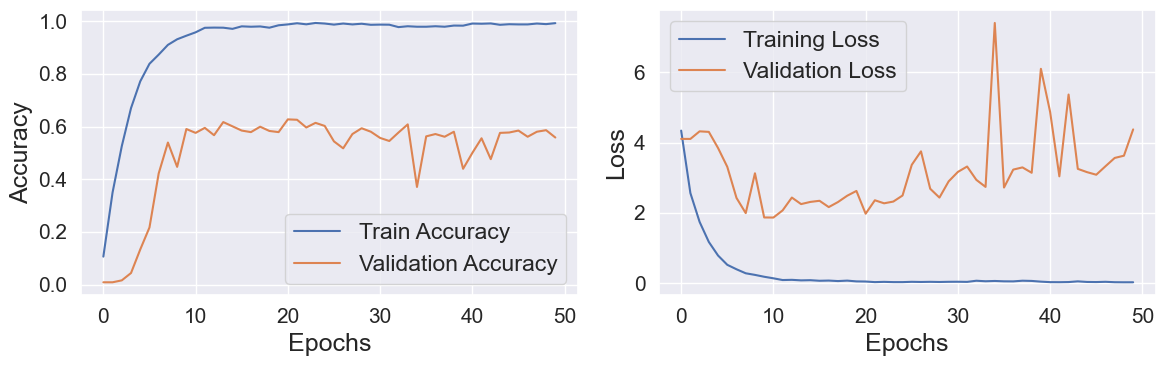

22/22 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0       0.38      0.21      0.27        14
           1       0.38      0.27      0.32        11
           2       0.88      0.70      0.78        10
           3       0.81      0.65      0.72        20
           4       1.00      0.29      0.44        14
           5       0.72      0.81      0.76        16
           6       0.62      0.56      0.59         9
           7       0.90      0.60      0.72        15
           8       0.41      0.58      0.48        12
           9       0.64      0.64      0.64        11
           A       0.56      0.94      0.70        16
           B       0.40      0.67      0.50         9
           C       0.57      0.44      0.50         9
           D       0.77      1.00      0.87        10
           E       0.71      0.67      0.69        15
           F       0.48      0.71      0.57        14
           G       1.00    

C:\Users\bobev\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bobev\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bobev\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
#Run Model off of tuned Hyperparameters

#----------------------------------------------------------------

import cv2
import os
import numpy as np
from PIL import Image
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import glob
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_tuner import HyperParameters

# Get the current directory
current_directory = os.getcwd()

# Specify the folder name where the images are located
folder_name = "img"

# Construct the folder path
folder_path = os.path.join(current_directory, folder_name)

# Specify the CSV file path containing image labels
csv_file_path = os.path.join(current_directory, "labels", "english-clean.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Create a dictionary where keys are filenames and values are labels
labels_dict = df.set_index('image')['label'].to_dict()

def load_images_from_folder(folder, labels_dict):
    images = []
    labels = []
    for file_path in glob.glob(os.path.join(folder, "*.png")):
        img = Image.open(file_path)
        if img is not None:
            img = img.convert('L')  # Convert image to grayscale
            img = img.resize((64, 64))  # Resize the image
            np_img = np.array(img)
            images.append(np_img)
            filename = os.path.basename(file_path)
            label = labels_dict[filename]  # Get the label from the filename
            labels.append(label)
    return images, labels

images, labels = load_images_from_folder(folder_path, labels_dict)

le = preprocessing.LabelEncoder()
numerical_labels = le.fit_transform(labels)  # Convert labels to integers

images = np.array(images)  # Convert list of arrays to a single array
images = images / 255.0  # Normalize pixel values
images = images.reshape(-1, 64, 64, 1)  # Reshape array for CNN

encoded_labels = to_categorical(numerical_labels)  # One-hot encode labels

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42, shuffle=True)

# Specify the file path to the saved hyperparameters
hyperparameters_file_path = 'best_hyperparameters.pkl'

# Load the saved hyperparameters
with open(hyperparameters_file_path, 'rb') as file:
    loaded_hyperparameters_dict = pickle.load(file)

# Create a new HyperParameters object and set the loaded hyperparameters
loaded_hyperparameters = HyperParameters()
loaded_hyperparameters.values = loaded_hyperparameters_dict

def build_model(hp):
    model = Sequential()

    # First block of convolutions
    model.add(Conv2D(loaded_hyperparameters.get('conv_1_units'), 
                     (3, 3), 
                     activation='relu', 
                     input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(loaded_hyperparameters.get('dropout_1')))

    # Second block of convolutions
    model.add(Conv2D(loaded_hyperparameters.get('conv_2_units'), 
                     (3, 3), 
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(loaded_hyperparameters.get('dropout_2')))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(loaded_hyperparameters.get('dense_1_units'), activation='relu'))
    model.add(Dropout(loaded_hyperparameters.get('dropout_3')))
    model.add(Dense(len(le.classes_), activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(loaded_hyperparameters.get('learning_rate')), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=100)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Build and train the model with the loaded hyperparameters
best_model = build_model(loaded_hyperparameters)
history = best_model.fit(X_train, 
                         y_train, 
                         epochs=50, 
                         validation_data=(X_test, y_test), 
                         callbacks=[early_stopping, model_checkpoint])

# Plotting the accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print a classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


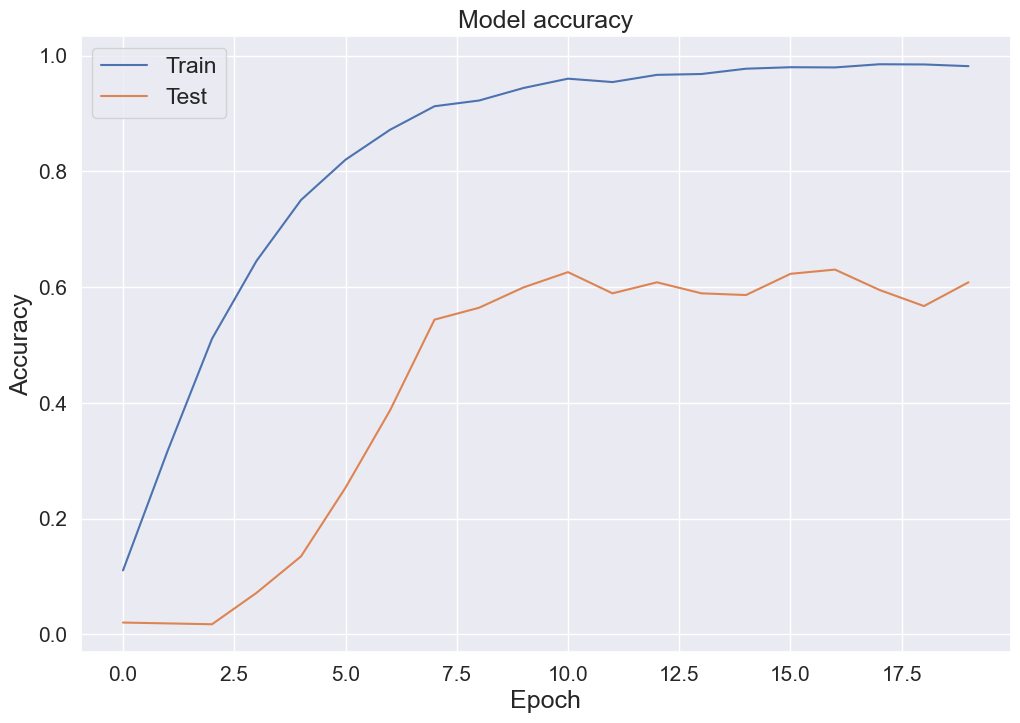

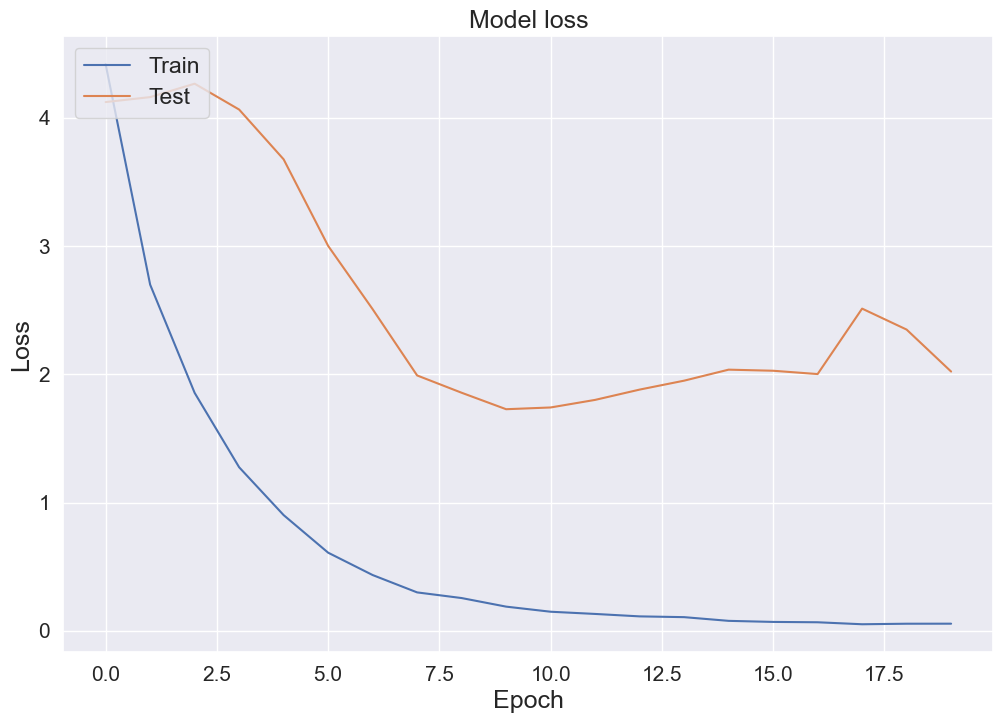

Evaluate on test data
6/6 [==============================] - 0s 54ms/step - loss: 2.0213 - accuracy: 0.6085
test loss, test accuracy: [2.0212836265563965, 0.6085044145584106]


In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=[12,8])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=[12,8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = best_model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test accuracy:", results)

In [8]:
# #Save Model For Furture Use
# model.save('EpochTenThousand')

In [9]:
# import pickle

# # Assume you have a history object from model.fit
# # history = model.fit(....)

# # Save it under some name
# with open('trainHistoryDict', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)


In [10]:
# with open('trainHistoryDict', 'rb') as file_pi:
#     loaded_history = pickle.load(file_pi)

In [19]:
# Evaluate the model on the training set
train_loss, train_accuracy = best_model.evaluate(X_train, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

86/86 [==============================] - 1s 16ms/step - loss: 0.0945 - accuracy: 0.9736
Train Loss: 0.09450731426477432
Train Accuracy: 0.973607063293457


In [20]:
# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, zero_division=1))

# Print confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(confusion_mtx)

22/22 [==============================] - 0s 16ms/step - loss: 4.3774 - accuracy: 0.5587
Test Loss: 4.377440929412842
Test Accuracy: 0.5586510300636292
22/22 [==============================] - 0s 16ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.21      0.27        14
           1       0.38      0.27      0.32        11
           2       0.88      0.70      0.78        10
           3       0.81      0.65      0.72        20
           4       1.00      0.29      0.44        14
           5       0.72      0.81      0.76        16
           6       0.62      0.56      0.59         9
           7       0.90      0.60      0.72        15
           8       0.41      0.58      0.48        12
           9       0.64      0.64      0.64        11
          10       0.56      0.94      0.70        16
          11       0.40      0.67      0.50         9
          12       0.57      0.44      0.50         9
          13   

22/22 [==============================] - 0s 15ms/step


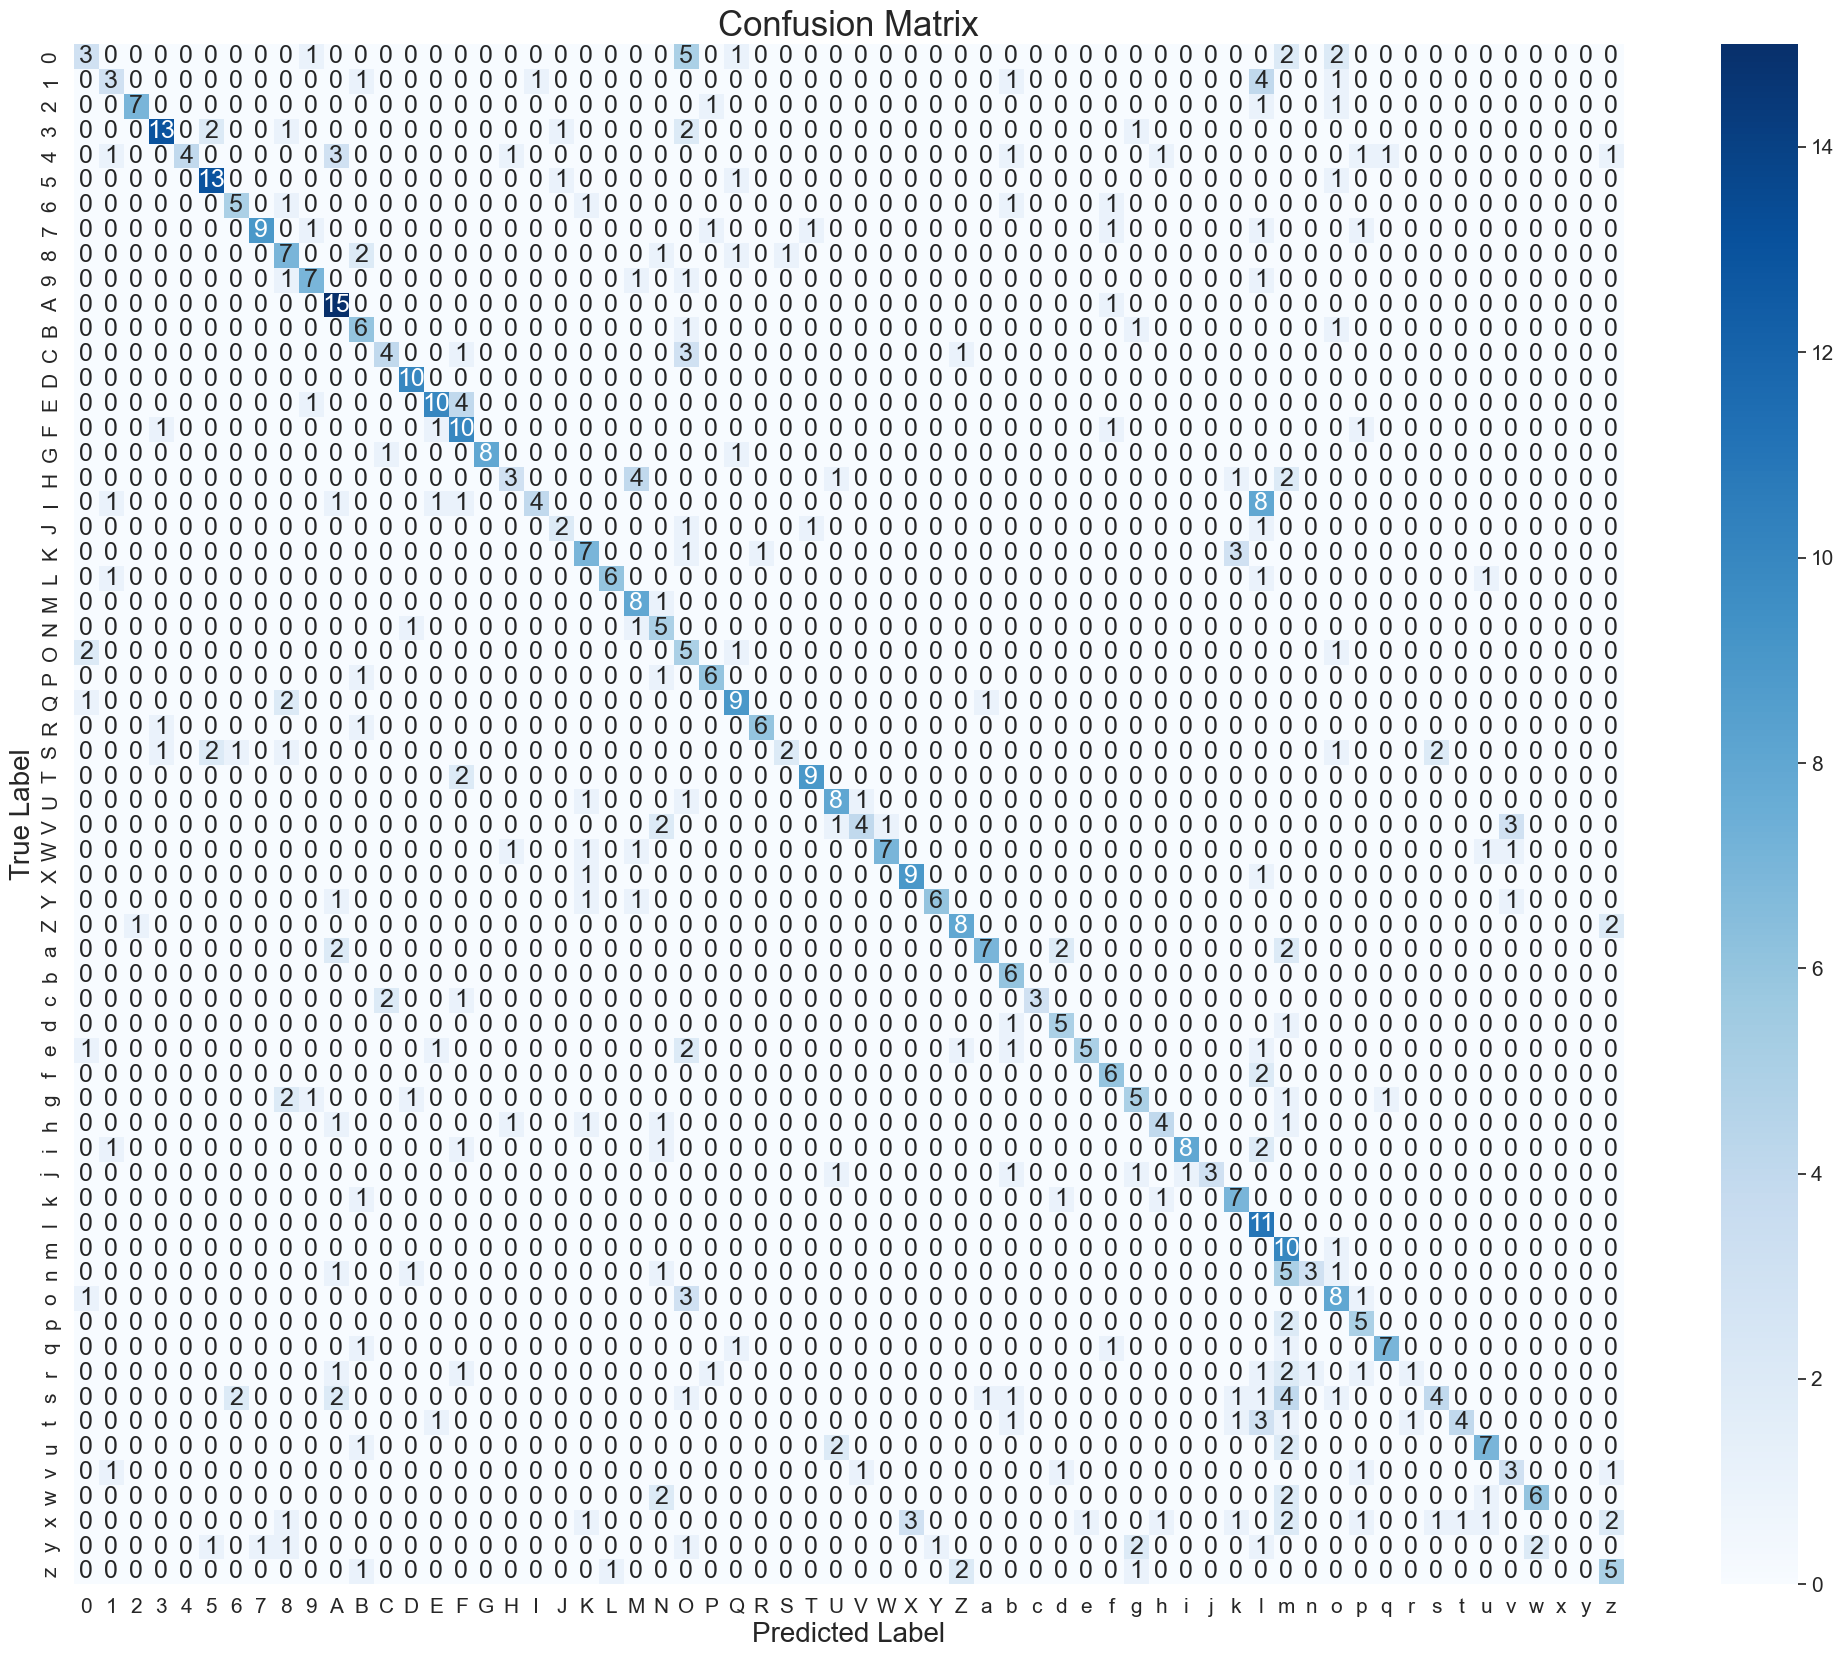

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert probabilities to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Also convert the one-hot encoded labels back to label encoding
y_true_labels = np.argmax(y_test, axis=1)

# Convert numerical labels back to original labels
y_pred_labels = le.inverse_transform(y_pred_labels)
y_true_labels = le.inverse_transform(y_true_labels)

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

# Create a list of unique labels
labels = list(le.classes_)

# Set the font scale (this will affect heatmap annotation size)
sns.set(font_scale=1.5)

# Adjust size of labels, title using rcParams
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

# Visualize confusion matrix using seaborn's heatmap
plt.figure(figsize=(25, 20))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.show()
